#Library

In [1]:
import re 
import pickle 
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn import metrics
from collections import defaultdict
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from keras.models import load_model
from pathlib import Path


# **Prepare datasets**

In [2]:
df= pd.read_csv(r'../../data/train_preprocess.tsv.txt', sep='\t', names=['text', 'label'])
df_alay = pd.read_csv('D:/Binar/Challenge/Binarchallenge2/tugas_dsc/data/new_kamusalay.csv', names=['alay','cleaned'],encoding='latin-1')
stopwords_dict = pd.read_csv('D:/Binar/Challenge/Binarchallenge2/tugas_dsc/data/stopwordbahasa.csv', names=['stopword'])

In [3]:
df.head()

,0,1
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [4]:
df.shape

(11000, 2)

#Check Data

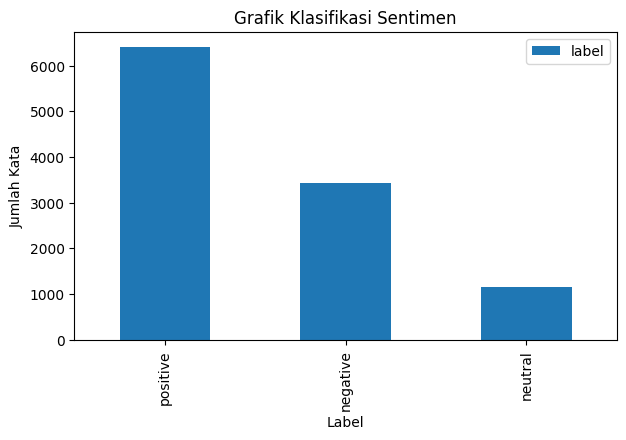

In [6]:
df["label"].value_counts().plot.pie(figsize=(7,4), autopct='%1.0f%%')
plt.title('Grafik Klasifikasi Sentimen')
plt.xlabel('Label')
plt.ylabel('Jumlah Kata')
plt.show()


In [7]:
df.label.value_counts()

positive    6416
negative    3436
neutral     1148
Name: label, dtype: int64

Kita cek isi datasetnya dan di dalamnya terdapat 11000 data. Terdiri dari:


*   Positive: 6416
*   Neutral: 1148
*   Negative: 3436



# **Text Normalization/Cleansing**

Cleansing data (sumber dari challenge sebelumnya)

In [8]:
def lowercase(text): # lowercase
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('RT',' ',text) # Remove every retweet symbol 
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

def remove_emoji(text):
    subs = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    text_emo = subs.sub(r'',text)
    return text_emo

def preprocess(text):
    text = lowercase(text) # 1
    text = remove_unnecessary_char(text) #2
    text = remove_nonaplhanumeric(text) # 3
    text = remove_emoji(text) #4
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mothy\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mothy\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [9]:
df['text_clean'] = df.text.apply(preprocess)

In [10]:
df.head()

,text,label,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k212 mmbri hujjah partai...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatera bandung tem...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh jadi mahasiswa jangan sombong dong kasih k...


#Sortir Data Berdasarkan 3 Sentimen

In [12]:
neg = df.loc[df['label'] == 'negative'].text_clean.tolist()
neu = df.loc[df['label'] == 'neutral'].text_clean.tolist()
pos = df.loc[df['label'] == 'positive'].text_clean.tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral'].label.tolist()
pos_label = df.loc[df['label'] == 'positive'].label.tolist()

total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print('Pos: %s, Neu: %s, Neg: %s' % (len(pos), len(neu), len(neg)))
print('Total data: %s' % len(total_data))


Pos: 6416, Neu: 1148, Neg: 3436
Total data: 11000


#Feature Extraction

In [13]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('tokenizer.pickle has created!')

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle','wb') as handle:
  pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('x_pad_sequences.pickle has created!')

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [14]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
  pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('y_labels.pickle has created!')

y_labels.pickle has created!


#Split Dataset For Training & Testing

In [15]:
file = open('x_pad_sequences.pickle','rb')
X = pickle.load(file)
file.close()

file = open('y_labels.pickle','rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

#Training (LSTM)

In [27]:
embed_dim = 64
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

adam = optimizers.legacy.Adam(learning_rate = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 79, 64)            6400000   
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dense_9 (Dense)             (None, 3)                 195       
                                                                 
Total params: 6,433,219
Trainable params: 6,433,219
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
880/880 [==============================] - 29s 32ms/step - loss: 0.5132 - accuracy: 0.7940 - val_loss: 0.3842 - val_accuracy: 0.8550
Epoch 2/10
880/880 [==============================] - 29s 33ms/step - loss: 0.2319 - accuracy: 0.9132 - val_loss: 0.4026 - val_accuracy: 0.8532
Epoch 2: early

#Evaluation

In [28]:
predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('Testing selesai')
print(matrix_test)

69/69 [==============================] - 0s 5ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       685
           1       0.73      0.76      0.75       233
           2       0.89      0.93      0.91      1282

    accuracy                           0.85      2200
   macro avg       0.82      0.81      0.81      2200
weighted avg       0.85      0.85      0.85      2200



#Cross Validation

In [29]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 64
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

    adam = optimizers.legacy.Adam(learning_rate = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
   
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1,  callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)


Epoch 1/10
880/880 [==============================] - 31s 34ms/step - loss: 0.5119 - accuracy: 0.7923 - val_loss: 0.3860 - val_accuracy: 0.8545
Epoch 2/10
880/880 [==============================] - 29s 34ms/step - loss: 0.2262 - accuracy: 0.9170 - val_loss: 0.4048 - val_accuracy: 0.8632
Epoch 2: early stopping
69/69 [==============================] - 0s 5ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.84      0.77      0.80       685
           1       0.78      0.81      0.80       233
           2       0.89      0.92      0.91      1282

    accuracy                           0.86      2200
   macro avg       0.84      0.83      0.83      2200
weighted avg       0.86      0.86      0.86      2200

Epoch 1/10
880/880 [==============================] - 31s 34ms/step - loss: 0.5102 - accuracy: 0.7915 - val_loss: 0.3754 - val_accuracy: 0.8609
Epoch 2/10
880/880 [==============================] - 30s 34ms/step - loss: 0.2317 - accuracy: 

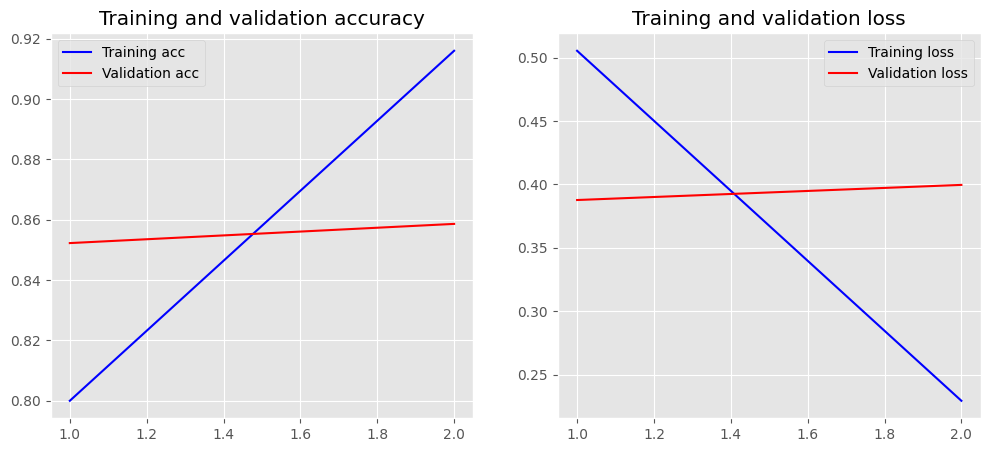

In [30]:
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) +1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1,2,1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

%matplotlib inline
plot_history(history)
  

#Export Model

In [31]:
model.save('model_lstm.h5')


#Testing Model

In [35]:
input_text = """ 
anaknya pinter banget.
"""

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model_lstm.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print('Text: ',text[0])
print('Sentiment: ',sentiment[polarity])

1/1 [==============================] - 0s 95ms/step
Text:  anaknya pinter banget
Sentiment:  positive
